In [8]:
example_name = "Binary_Test"
test_dir = f"test_dirs/{example_name}"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $test_dir
    os.chdir(test_dir)
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
print(f"Current working directory: {os.getcwd()}")
print(f"Repository root directory: {repo_root}")

Current working directory: /workspaces/fargocpt/test_dirs/Binary_Test
Repository root directory: /workspaces


In [9]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C $repo_root/fargocpt/src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

502 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
configfile = "setup.yml"
#!cp $repo_root/fargocpt/test_dirs/Binary_Test/set.yml $configfile

In [19]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [20]:
#config["nbody"][1]["accretion efficiency"] = "2"
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 20 # write a snapshot after every 20 monitor timesteps = every orbit
config["Nsnapshots"] = 10 # wirte 10 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
config["cps"] = 2

with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

In [21]:
from fargocpt import run
np = 2 # Number of mpi processes. Should be equal to the number of numa nodes on your machine, check your cluster docu or run `lscpu` or `./run_fargo --print-numa` if you're on linux.
nt = 1 # Number of threads per mpi process, set it to the number of cores you want to use / number of MPI processes
run(["start", configfile], np=np, nt=nt, exe=repo_root+"/fargocpt/bin/fargocpt_exe", detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp0h1zenbm -x OMP_NUM_THREADS=1 /workspaces/fargocpt/bin/fargocpt_exe start setup.yml
fargo process pid 37558

[0] MPI rank #  0 runs as process 37562
[1] MPI rank #  1 runs as process 37563
[0] MPI rank #  0 OpenMP thread #  0 of  1 on codespaces-f4c61d
[1] MPI rank #  1 OpenMP thread #  0 of  1 on codespaces-f4c61d
[0] fargo: This file was compiled on May 15 2024, 21:56:12.
[0] fargo: Last git commit: e9b10d840e009719d3266c72c13697b63ce658e2
[0] fargo: Files changed since git commit: 
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 3.20000e+01 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad 

0

In [22]:
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt

def plot_field(loader, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis", title=None):
    R, PHI, vals = loader.gas.vars2D.get(name, N, grid_for_plot=True)
    if dataunit is None:
        dataunit = vals.unit
    C = vals.to_value(dataunit)

    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)

    # Hacky way to support arrays that are defined on the radial interfaces
    if C.shape[0] == X.shape[0]:
        C = C[:-1,:]

    pcm = ax.pcolormesh(X,Y,C, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = loader.snapshot_time[N].to_value("kyr")
    if title is None:
        title = ""
    else:
        title += "\n"
    title += f" t={t:.2e}kyr, N={N}"
    ax.set_title(title)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

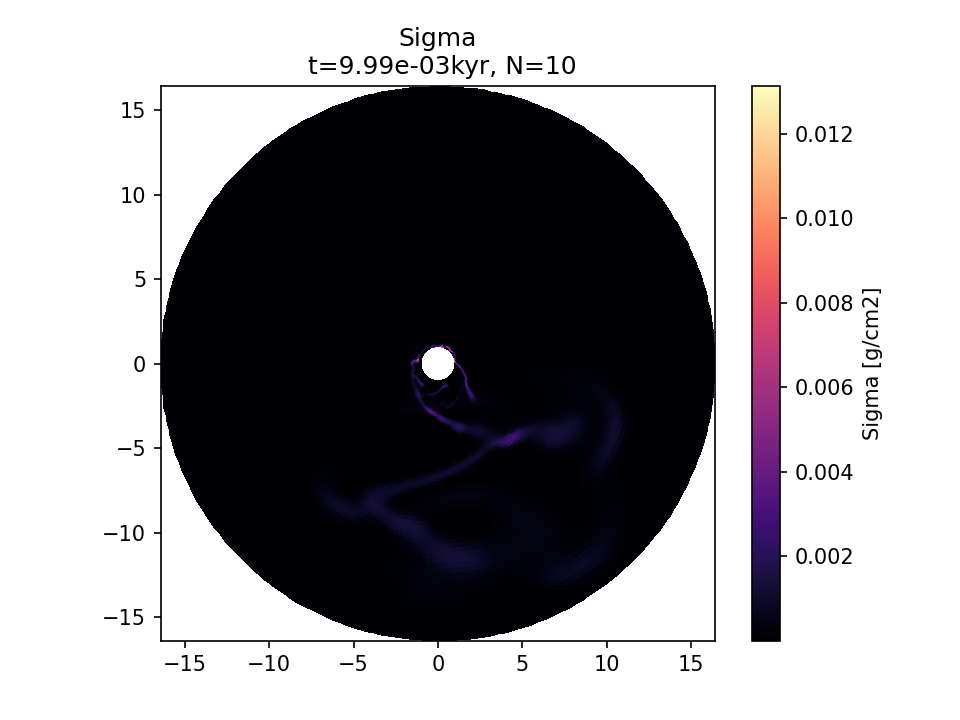

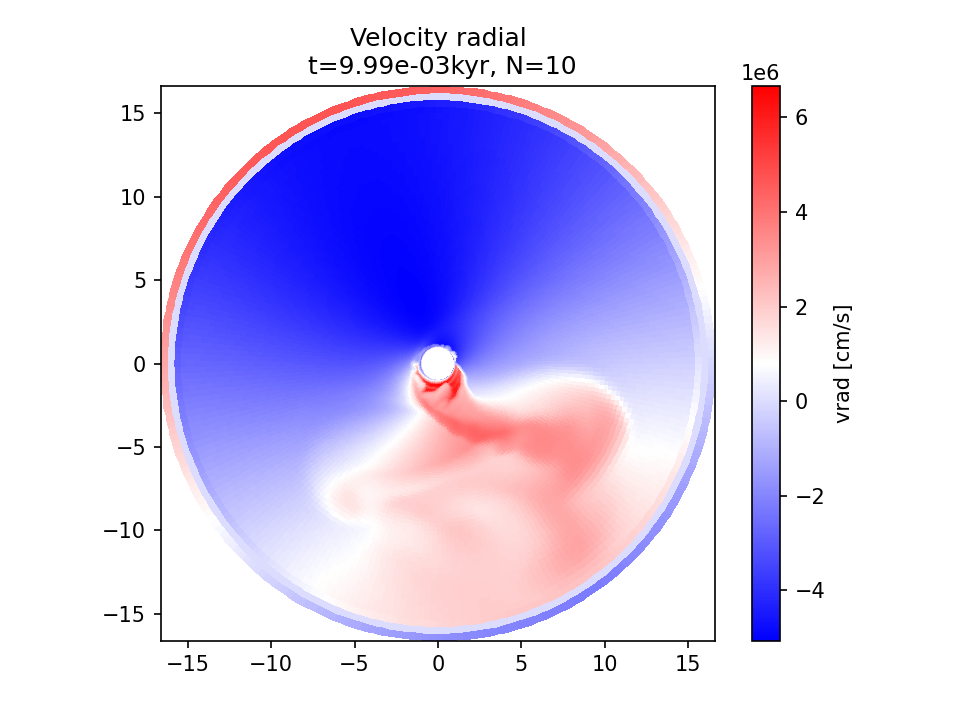

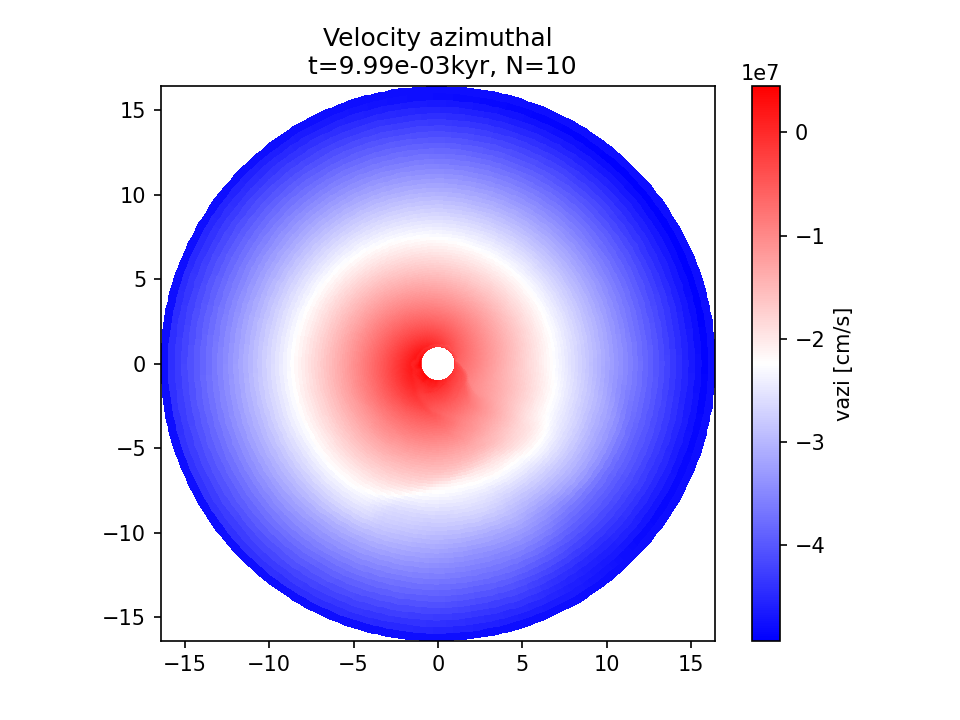

In [23]:
%matplotlib widget
from fargocpt import Loader
l = Loader("output/out/")
Nlast = l.snapshots[-1]
plot_field(l, "Sigma", Nlast, dataunit="g/cm2", cmap="magma", title="Sigma");
plot_field(l, "vrad", Nlast, dataunit="cm/s", cmap="bwr", title="Velocity radial");
plot_field(l, "vazi", Nlast, dataunit="cm/s", cmap="bwr", title="Velocity azimuthal");